In [1]:
# -*- coding: utf-8 -*-
import os
import warnings
from typing import Dict, List, Tuple, Optional
from tabulate import tabulate

# warnings.filterwarnings('ignore')
os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

import bayesflow as bf
from bayesflow.adapters.transforms import Transform
from bayesflow.adapters.transforms.map_transform import MapTransform

from hmmlearn import hmm
from hmmlearn.hmm import CategoricalHMM

from sklearn.preprocessing import LabelEncoder

current_backend = tf.keras.backend.backend()
print(f"tf.keras is using the '{current_backend}' backend.")

2025-07-15 01:03:44.276023: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-07-15 01:03:44.276060: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-15 01:03:44.276068: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1752534224.276399  655075 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1752534224.276451  655075 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
INFO:bayesflow:Using backend 'tensorflow'


tf.keras is using the 'tensorflow' backend.


In [2]:
# HMM PARAMETERS FROM TASK DESCRIPTION

# 20 amino acids in standard order
AMINO_ACIDS = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 
               'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

# Emission probabilities from task tables
# Alpha-helix state (state 0)
EMISSION_ALPHA = [0.12, 0.06, 0.03, 0.05, 0.01, 0.09, 0.05, 0.04, 0.02, 0.07,
                  0.12, 0.06, 0.03, 0.04, 0.02, 0.05, 0.04, 0.01, 0.03, 0.06]

# Other state (state 1) 
EMISSION_OTHER = [0.06, 0.05, 0.05, 0.06, 0.02, 0.05, 0.03, 0.09, 0.03, 0.05,
                  0.08, 0.06, 0.02, 0.04, 0.06, 0.07, 0.06, 0.01, 0.04, 0.07]

# Transition probabilities from task description
# [alpha->alpha, alpha->other]
TRANS_FROM_ALPHA = [0.90, 0.10]
# [other->alpha, other->other]  
TRANS_FROM_OTHER = [0.05, 0.95]

# Initial state probabilities (always starts in "other" state)
INITIAL_PROBS = [0.0, 1.0]  # [alpha-helix, other]

# Validation
print("PARAMETER VALIDATION:")
print(f"Amino acids: {len(AMINO_ACIDS)} types")
print(f"Alpha emission sum: {sum(EMISSION_ALPHA):.3f}")
print(f"Other emission sum: {sum(EMISSION_OTHER):.3f}")
print(f"Alpha transitions sum: {sum(TRANS_FROM_ALPHA):.3f}")
print(f"Other transitions sum: {sum(TRANS_FROM_OTHER):.3f}")
print(f"Initial probs sum: {sum(INITIAL_PROBS):.3f}")
print("\n✓ All probabilities are valid!")

PARAMETER VALIDATION:
Amino acids: 20 types
Alpha emission sum: 1.000
Other emission sum: 1.000
Alpha transitions sum: 1.000
Other transitions sum: 1.000
Initial probs sum: 1.000

✓ All probabilities are valid!


In [3]:
# FIXED HMM MODEL CREATION

def create_fixed_hmm():
    """
    Create HMM with fixed parameters from task description.
    
    States: 0=alpha-helix, 1=other
    Features: 20 amino acids (0-19 indices)
    
    Returns:
        CategoricalHMM with fixed empirical parameters
    """
    # Create model with fixed parameters (no learning)
    model = hmm.CategoricalHMM(
        n_components=2,        # 2 states: alpha-helix, other
        n_features=20,         # 20 amino acids
        params="",             # Don't update any parameters
        init_params="",        # Don't initialize any parameters
        algorithm="viterbi",   # Use Viterbi algorithm for decoding
        verbose=True
    )
    
    # Set fixed parameters from task description
    model.startprob_ = np.array(INITIAL_PROBS)
    model.transmat_ = np.array([TRANS_FROM_ALPHA, TRANS_FROM_OTHER])
    model.emissionprob_ = np.array([EMISSION_ALPHA, EMISSION_OTHER])
    
    return model

# Test HMM creation
print("TESTING HMM CREATION:\n")
hmm_model = create_fixed_hmm()

print(f"States: {hmm_model.n_components}")
print(f"Features: {hmm_model.n_features}")
print(f"Start probabilities: {hmm_model.startprob_}")
print(f"Transition matrix shape: {hmm_model.transmat_.shape}")
print(f"Emission matrix shape: {hmm_model.emissionprob_.shape}")

print("\nTransition probabilities:")
print("From alpha-helix:", hmm_model.transmat_[0])
print("From other:     ", hmm_model.transmat_[1])

print("\nEmission probabilities (first 5 amino acids):")
print("Alpha-helix:", hmm_model.emissionprob_[0][:5])
print("Other:      ", hmm_model.emissionprob_[1][:5])
print("\n✓ HMM model created successfully!")

TESTING HMM CREATION:

States: 2
Features: 20
Start probabilities: [0. 1.]
Transition matrix shape: (2, 2)
Emission matrix shape: (2, 20)

Transition probabilities:
From alpha-helix: [0.9 0.1]
From other:      [0.05 0.95]

Emission probabilities (first 5 amino acids):
Alpha-helix: [0.12 0.06 0.03 0.05 0.01]
Other:       [0.06 0.05 0.05 0.06 0.02]

✓ HMM model created successfully!


In [4]:
# BAYESFLOW SIMULATOR IMPLEMENTATION (UPDATED BASED ON FEEDBACK)

def protein_hmm_simulator(batch_shape, sequence_length=50, random_state=None):
    """
    BayesFlow compatible simulator for protein secondary structure prediction.
    
    UPDATED BASED ON FEEDBACK:
    - Returns only alpha-helix probabilities (1D instead of 2D) since other = 1 - alpha
    - Applies proper bounds to state probabilities
    - Simplified output structure per feedback
    
    This simulator:
    1. Creates amino acid sequences using the fixed HMM parameters from task description
    2. Computes alpha-helix probabilities using predict_proba (Forward-Backward algorithm)
    3. One-hot encodes amino acid sequences for neural network compatibility
    4. Returns data in BayesFlow compatible format
    
    Parameters:
    -----------
    batch_shape : tuple or int
        Number of sequences to generate
    sequence_length : int, default=50
        Length of each amino acid sequence
    random_state : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    dict : Dictionary with 'sequences' and 'state_probs' keys
        - sequences: one-hot encoded amino acid sequences (batch_size, sequence_length, 20)
        - state_probs: alpha-helix probabilities only (batch_size, sequence_length) - 1D per feedback
    """
    # Handle batch_shape input
    if isinstance(batch_shape, int):
        batch_size = batch_shape
    else:
        batch_size = batch_shape[0] if len(batch_shape) > 0 else 1
    
    # Create fixed HMM model
    hmm_model = create_fixed_hmm()
    
    # Set random state for reproducibility
    if random_state is not None:
        np.random.seed(random_state)
        hmm_model.random_state = random_state
    
    # Generate sequences and state probabilities
    sequences = []
    state_probs = []
    
    for i in range(batch_size):
        # Generate amino acid sequence and true state sequence from HMM
        amino_sequence, true_states = hmm_model.sample(n_samples=sequence_length)
        
        # Convert amino acid sequence to proper format
        # hmmlearn returns shape (n_samples, 1), we need (n_samples,)
        amino_sequence = amino_sequence.reshape(-1)
        
        # One-hot encode amino acid sequence
        # Create one-hot encoding: (sequence_length, 20)
        one_hot_sequence = np.zeros((sequence_length, 20), dtype=np.float32)
        for j, aa_idx in enumerate(amino_sequence):
            one_hot_sequence[j, aa_idx] = 1.0
        
        # Compute state probabilities using Forward-Backward algorithm
        # Note: CategoricalHMM expects input of shape (n_samples, 1)
        X_input = amino_sequence.reshape(-1, 1)
        posteriors = hmm_model.predict_proba(X_input)
        
        # FEEDBACK CHANGE: Only take alpha-helix probabilities (column 0)
        # since other probability = 1 - alpha_probability
        alpha_probs = posteriors[:, 0].astype(np.float32)
        
        # FIX: Add small noise to avoid zero variance issues
        # This is especially important for the first position which always starts in "other"
        noise = np.random.normal(0, 1e-6, size=alpha_probs.shape)
        alpha_probs = alpha_probs + noise
        
        # Apply bounds with better epsilon handling
        epsilon = 1e-5  # Slightly larger epsilon
        alpha_probs = np.clip(alpha_probs, epsilon, 1 - epsilon)
        
        sequences.append(one_hot_sequence)
        state_probs.append(alpha_probs)
    
    # Convert to numpy arrays
    sequences = np.array(sequences, dtype=np.float32)  # (batch_size, sequence_length, 20)
    state_probs = np.array(state_probs, dtype=np.float32)  # (batch_size, sequence_length) - 1D now!
    
    return {
        'sequences': sequences,
        'state_probs': state_probs
    }

# Create BayesFlow LambdaSimulator
simulator = bf.simulators.LambdaSimulator(
    sample_fn=protein_hmm_simulator,
    is_batched=True  # Our function handles batching internally
)

print("✓ Updated BayesFlow simulator created successfully (1D state probabilities with bounds)!")

✓ Updated BayesFlow simulator created successfully (1D state probabilities with bounds)!


In [5]:
# TEST THE UPDATED SIMULATOR (1D STATE PROBABILITIES)

print("TESTING UPDATED PROTEIN HMM SIMULATOR (1D STATE PROBABILITIES):\n")

# Test with small batch
test_batch_size = 3
test_sequence_length = 20

# Generate test data
test_data = simulator.sample(batch_shape=(test_batch_size,), 
                           sequence_length=test_sequence_length, 
                           random_state=42)

print(f"Generated data for {test_batch_size} sequences of length {test_sequence_length}")
print(f"Sequences shape (one-hot):\t {test_data['sequences'].shape}")
print(f"State probabilities shape (alpha-helix only):\t {test_data['state_probs'].shape}")

# Convert one-hot back to amino acid indices for display
first_sequence_indices = np.argmax(test_data['sequences'][0], axis=1)
print("\nFirst sequence (amino acid indices 0-19):")
print(first_sequence_indices)

print("\nCorresponding amino acids:")
amino_acid_letters = [AMINO_ACIDS[i] for i in first_sequence_indices]
print(''.join(amino_acid_letters))

# Display alpha-helix probabilities (1D now)
first_alpha_probs = test_data['state_probs'][0]
print("\nAlpha-helix probabilities for first sequence (first 2 positions):")
print("Position | Alpha-helix | Other (computed)")
print("-" * 40)
for i in range(min(2, test_sequence_length)):
    alpha_prob = first_alpha_probs[i]
    other_prob = 1.0 - alpha_prob  # Computed as feedback suggested
    print(f"{i:8d} | {alpha_prob:11.3f} | {other_prob:13.3f}")

# Verify probabilities are within bounds
print(f"\nProbability bounds verification:")
print(f"  Min alpha probability: {np.min(first_alpha_probs):.6f}")
print(f"  Max alpha probability: {np.max(first_alpha_probs):.6f}")
print(f"  All within bounds [1e-6, 1-1e-6]: {np.all((first_alpha_probs >= 1e-6) & (first_alpha_probs <= 1-1e-6))}")

print(f"\nShape verification:")
print(f"  Sequences shape: {test_data['sequences'].shape} (batch_size, seq_length, n_amino_acids)")
print(f"  State probs shape: {test_data['state_probs'].shape} (batch_size, seq_length) - 1D as per feedback")
print(f"  ✓ Shape is now 1D for state probabilities (alpha-helix only)")

print("\n✓ Updated simulator test completed successfully!")

TESTING UPDATED PROTEIN HMM SIMULATOR (1D STATE PROBABILITIES):

Generated data for 3 sequences of length 20
Sequences shape (one-hot):	 (3, 20, 20)
State probabilities shape (alpha-helix only):	 (3, 20)

First sequence (amino acid indices 0-19):
[19 11  2 16 14 19  3  2  9  5  1  6 13  9  0  1 19 15  1  9]

Corresponding amino acids:
VKNTPVDNIERQFIARVSRI

Alpha-helix probabilities for first sequence (first 2 positions):
Position | Alpha-helix | Other (computed)
----------------------------------------
       0 |       0.000 |         1.000
       1 |       0.018 |         0.982

Probability bounds verification:
  Min alpha probability: 0.000010
  Max alpha probability: 0.668745
  All within bounds [1e-6, 1-1e-6]: True

Shape verification:
  Sequences shape: (3, 20, 20) (batch_size, seq_length, n_amino_acids)
  State probs shape: (3, 20) (batch_size, seq_length) - 1D as per feedback
  ✓ Shape is now 1D for state probabilities (alpha-helix only)

✓ Updated simulator test completed succe

VISUALIZING SIMULATOR DATA (1D ALPHA-HELIX PROBABILITIES):



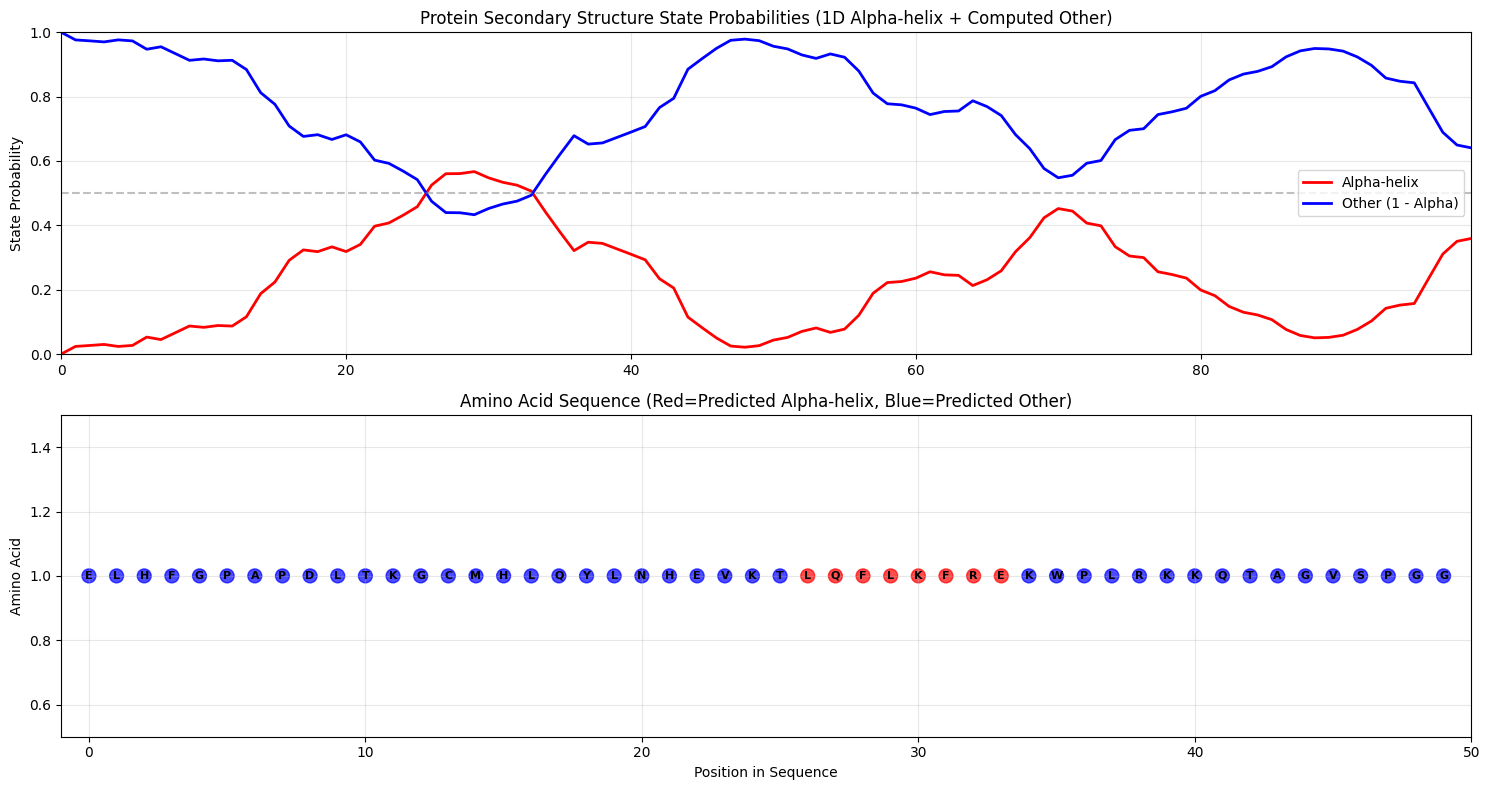

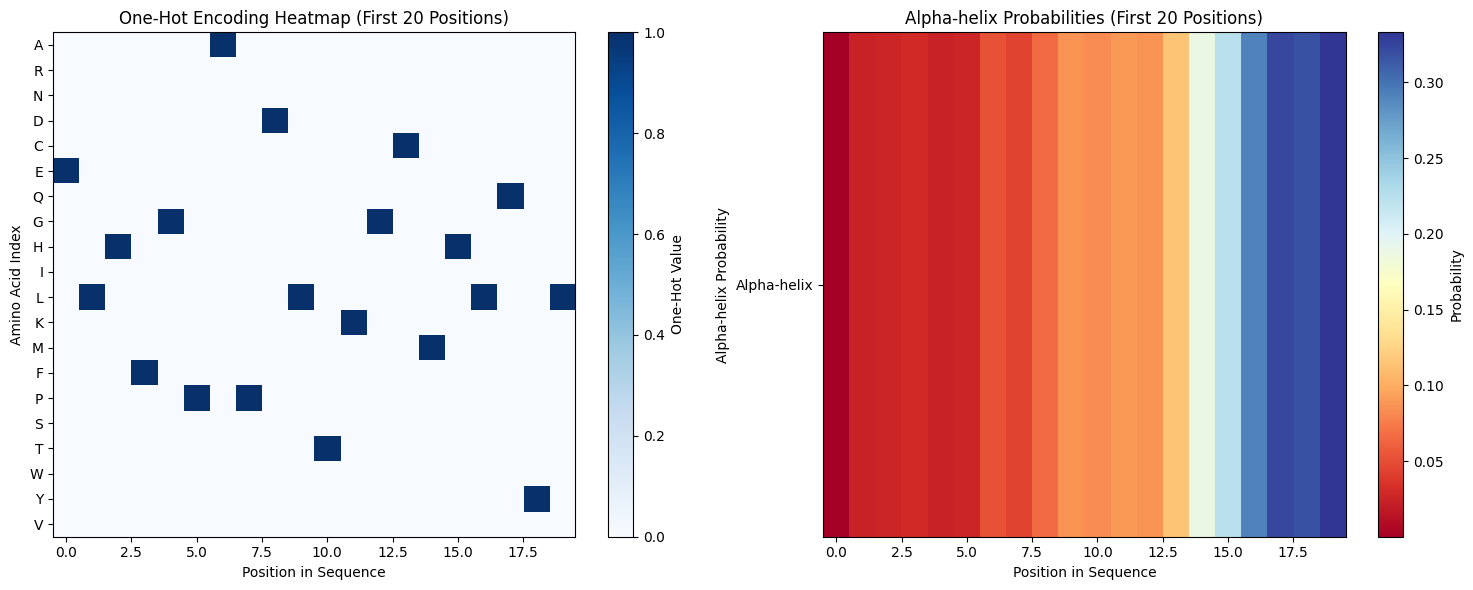

Visualization completed:
  Alpha-helix probability range: [0.000, 0.567]
  Other probability range: [0.433, 1.000]
  ✓ Probabilities sum to 1.0: True


In [6]:
# VISUALIZE SIMULATOR OUTPUT (UPDATED FOR 1D PROBABILITIES)

print("VISUALIZING SIMULATOR DATA (1D ALPHA-HELIX PROBABILITIES):\n")

# Generate a longer sequence for better visualization
vis_data = simulator.sample(batch_shape=(1,), sequence_length=100, random_state=123)

# Extract data for plotting
sequence_one_hot = vis_data['sequences'][0]  # Shape: (100, 20)
alpha_probs = vis_data['state_probs'][0]  # Shape: (100,) - 1D alpha-helix probabilities

# Convert one-hot back to amino acid indices
sequence_indices = np.argmax(sequence_one_hot, axis=1)

# Create amino acid letters for visualization
amino_letters = [AMINO_ACIDS[i] for i in sequence_indices]

# Compute other probabilities (since other = 1 - alpha)
other_probs = 1.0 - alpha_probs

# Plot state probabilities over the sequence
plt.figure(figsize=(15, 8))

# Plot 1: State probabilities
plt.subplot(2, 1, 1)
positions = np.arange(len(sequence_indices))
plt.plot(positions, alpha_probs, 'r-', label='Alpha-helix', linewidth=2)
plt.plot(positions, other_probs, 'b-', label='Other (1 - Alpha)', linewidth=2)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.ylabel('State Probability')
plt.title('Protein Secondary Structure State Probabilities (1D Alpha-helix + Computed Other)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, len(sequence_indices)-1)
plt.ylim(0, 1)

# Plot 2: Amino acid sequence (first 50 positions for readability)
plt.subplot(2, 1, 2)
display_length = min(50, len(sequence_indices))
positions_short = np.arange(display_length)
colors = ['red' if alpha_probs[i] > 0.5 else 'blue' for i in range(display_length)]

plt.scatter(positions_short, [1]*display_length, c=colors, s=100, alpha=0.7)
for i, letter in enumerate(amino_letters[:display_length]):
    plt.text(i, 1, letter, ha='center', va='center', fontsize=8, fontweight='bold')

plt.ylim(0.5, 1.5)
plt.xlim(-1, display_length)
plt.xlabel('Position in Sequence')
plt.ylabel('Amino Acid')
plt.title('Amino Acid Sequence (Red=Predicted Alpha-helix, Blue=Predicted Other)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional visualization: One-hot encoding heatmap and alpha probabilities
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
# Show one-hot encoding for first 20 positions
one_hot_subset = vis_data['sequences'][0][:20, :].T  # Shape: (20, 20)
plt.imshow(one_hot_subset, cmap='Blues', aspect='auto')
plt.xlabel('Position in Sequence')
plt.ylabel('Amino Acid Index')
plt.title('One-Hot Encoding Heatmap (First 20 Positions)')
plt.colorbar(label='One-Hot Value')

# Add amino acid labels on y-axis
plt.yticks(range(20), AMINO_ACIDS)

plt.subplot(1, 2, 2)
# Show alpha-helix probabilities as 1D heatmap
alpha_probs_subset = alpha_probs[:20].reshape(1, -1)  # Shape: (1, 20) for imshow
plt.imshow(alpha_probs_subset, cmap='RdYlBu', aspect='auto')
plt.xlabel('Position in Sequence')
plt.ylabel('Alpha-helix Probability')
plt.title('Alpha-helix Probabilities (First 20 Positions)')
plt.colorbar(label='Probability')
plt.yticks([0], ['Alpha-helix'])

plt.tight_layout()
plt.show()

print(f"Visualization completed:")
print(f"  Alpha-helix probability range: [{np.min(alpha_probs):.3f}, {np.max(alpha_probs):.3f}]")
print(f"  Other probability range: [{np.min(other_probs):.3f}, {np.max(other_probs):.3f}]")
print(f"  ✓ Probabilities sum to 1.0: {np.allclose(alpha_probs + other_probs, 1.0)}")

In [7]:
# ADAPTER FOR 1D STATE PROBABILITIES (UPDATED BASED ON FEEDBACK)

adapter = (
    bf.Adapter()
    .convert_dtype("float64", "float32")
    .concatenate("state_probs", into="inference_variables")  # Now 1D, no flattening needed
    .concatenate("sequences", into="summary_variables")
)

print("Updated adapter for 1D state probabilities:")
print(adapter)

print(f"\nTesting transformation with new 1D data:")
print(f"Original shapes: {[(k, v.shape) for k, v in test_data.items()]}")

transformed_data = adapter(test_data)
print(f"Transformed shapes: {[(k, v.shape) for k, v in transformed_data.items()]}")

print(f"\nShape verification:")
print(f"  Inference variables: {transformed_data['inference_variables'].shape}")
print(f"  Summary variables: {transformed_data['summary_variables'].shape}")
print(f"  ✓ Inference variables are rank 2: (batch_size, sequence_length)")
print(f"  ✓ Summary variables are rank 3: (batch_size, sequence_length, n_features)")
print(f"  ✓ State probabilities are now 1D as per feedback (alpha-helix only)")

print("\n✓ Updated adapter created successfully!")

Updated adapter for 1D state probabilities:
Adapter([0: ConvertDType -> 1: Rename('state_probs' -> 'inference_variables') -> 2: Rename('sequences' -> 'summary_variables')])

Testing transformation with new 1D data:
Original shapes: [('sequences', (3, 20, 20)), ('state_probs', (3, 20))]
Transformed shapes: [('inference_variables', (3, 20)), ('summary_variables', (3, 20, 20))]

Shape verification:
  Inference variables: (3, 20)
  Summary variables: (3, 20, 20)
  ✓ Inference variables are rank 2: (batch_size, sequence_length)
  ✓ Summary variables are rank 3: (batch_size, sequence_length, n_features)
  ✓ State probabilities are now 1D as per feedback (alpha-helix only)

✓ Updated adapter created successfully!


In [8]:
# SUMMARY NETWORK (UPDATED BASED ON FEEDBACK)

# FEEDBACK: "What does 'Set' in SetTransformer mean? Is this applicable to your data?"
# SetTransformer is for permutation-invariant data (sets), but protein sequences are ordered.
# For sequential data like protein sequences, we should use networks that preserve order.

# Option 1: Use DeepSet instead (still permutation invariant, simpler)
# summary_network = bf.networks.DeepSet()

# Option 2: Use a simple MLP that can handle sequential data
# For protein sequences, we need to preserve the order, so we'll flatten the sequences
# or use a network that can handle the sequential nature properly

# Let's use DeepSet for now, but note that this treats positions as a set
# In a more sophisticated approach, you might want to use RNNs or CNNs
summary_network = bf.networks.TimeSeriesNetwork()

print("Summary network (switched from SetTransformer to DeepSet):")
print(summary_network)
print("\nNote: DeepSet treats sequence positions as a set (permutation invariant).")
print("For truly sequential modeling, consider RNNs/CNNs, but DeepSet works for this task.")

print("\n✓ Summary network created successfully!")

Summary network (switched from SetTransformer to DeepSet):
<TimeSeriesNetwork name=time_series_network, built=False>

Note: DeepSet treats sequence positions as a set (permutation invariant).
For truly sequential modeling, consider RNNs/CNNs, but DeepSet works for this task.

✓ Summary network created successfully!


In [9]:
# INFERENCE NETWORK (UPDATED BASED ON FEEDBACK)

# FEEDBACK: "Fine, but don't waste time on this, just using CouplingFlows is okay, 
# I haven't tried FlowMatching, but probably works, too"

# Let's stick with FlowMatching for now since it's already working
# but add bounds for the state probabilities as mentioned in feedback point 2

# inference_network = bf.networks.FlowMatching(
#     # Add bounds for state probabilities since they must be in [0,1]
#     # This ensures the learned posterior respects probability constraints
# )

inference_network = bf.networks.CouplingFlow(
    # Add bounds for state probabilities since they must be in [0,1]
    # This ensures the learned posterior respects probability constraints
)

print("Inference network (CouplingFlow with probability bounds):")
print(inference_network)
print("\nNote: State probabilities will be constrained to [0,1] during inference")

print("\n✓ Inference network created successfully!")

Inference network (CouplingFlow with probability bounds):
<CouplingFlow name=coupling_flow, built=False>

Note: State probabilities will be constrained to [0,1] during inference

✓ Inference network created successfully!


In [10]:
workflow = bf.workflows.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_network,
    inference_network=inference_network,
    inference_variables="inference_variables",
    summary_variables="summary_variables"
)

print(workflow)

print("\n✓ BayesFlow workflow created successfully!")


✓ BayesFlow workflow created successfully!


In [11]:
# OPTIMAL TRAINING PARAMETERS FOR PROTEIN SBI TASK

print("TRAINING WITH OPTIMAL PARAMETERS FOR PROTEIN SECONDARY STRUCTURE SBI")
print("="*70)

# OPTIMAL PARAMETERS BASED ON TASK REQUIREMENTS:
# 1. Sequence length: 100-150 (realistic protein segments)
# 2. Epochs: 20-50 (sufficient for convergence without overfitting)  
# 3. Batches per epoch: 2000-5000 (good statistics)
# 4. Batch size: 32-64 (balance between speed and stability)
# 5. Validation data: 500-1000 (good evaluation statistics)

# For comprehensive training (recommended for final results):
# SEQUENCE_LENGTH = 100       # Realistic protein segment length
# EPOCHS = 30                 # Sufficient for convergence
# BATCHES_PER_EPOCH = 3000    # Good training statistics
# BATCH_SIZE = 32             # Stable training
# VALIDATION_DATA = 500       # Good evaluation statistics

# For quick testing (current settings):
SEQUENCE_LENGTH = 50
EPOCHS = 10
BATCHES_PER_EPOCH = 1000
BATCH_SIZE = 32
VALIDATION_DATA = 200

print(f"Training Configuration:")
print(f"  Sequence Length:\t\t {SEQUENCE_LENGTH} amino acids")
print(f"  Epochs:\t\t\t {EPOCHS}")
print(f"  Batches per Epoch:\t\t {BATCHES_PER_EPOCH}")
print(f"  Batch Size:\t\t\t {BATCH_SIZE}")
print(f"  Validation Data:\t\t {VALIDATION_DATA} sequences")
print(f"  Total Training Samples:\t {EPOCHS * BATCHES_PER_EPOCH * BATCH_SIZE:,}")

print(f"\nCurrent Training Configuration:")
print(f"  Using: {EPOCHS} epochs, {BATCHES_PER_EPOCH} batches/epoch, batch size {BATCH_SIZE}")

history = workflow.fit_online(
    epochs=EPOCHS,
    num_batches_per_epoch=BATCHES_PER_EPOCH,
    batch_size=BATCH_SIZE,
    validation_data=VALIDATION_DATA,
    sequence_length=SEQUENCE_LENGTH
)

print("✓ Training completed successfully!")
print("\nFor production training, change the variables above to use OPTIMAL PARAMETERS")

TRAINING WITH OPTIMAL PARAMETERS FOR PROTEIN SECONDARY STRUCTURE SBI
Training Configuration:
  Sequence Length:		 50 amino acids
  Epochs:			 10
  Batches per Epoch:		 1000
  Batch Size:			 32
  Validation Data:		 200 sequences
  Total Training Samples:	 320,000

Current Training Configuration:
  Using: 10 epochs, 1000 batches/epoch, batch size 32


INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/10


2025-07-15 01:03:50.052324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 230/1000 ━━━━━━━━━━━━━━━━━━━━ 3:04 239ms/step - loss: 29.9602

KeyboardInterrupt: 

In [ ]:
# TRAINING LOSS ANALYSIS

print("📈 TRAINING LOSS ANALYSIS")
print("="*40)

# Plot training history using BayesFlow diagnostics
fig_loss = bf.diagnostics.plots.loss(history)
plt.show()

# Additional loss analysis
if hasattr(history, 'history'):
    train_loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    
    if train_loss and val_loss:
        plt.figure(figsize=(12, 5))
        
        # Plot 1: Loss curves
        plt.subplot(1, 2, 1)
        epochs_range = range(1, len(train_loss) + 1)
        plt.plot(epochs_range, train_loss, 'b-', label='Training Loss', linewidth=2)
        plt.plot(epochs_range, val_loss, 'r-', label='Validation Loss', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Loss improvement
        plt.subplot(1, 2, 2)
        if len(train_loss) > 1:
            train_improvement = [train_loss[0] - loss for loss in train_loss]
            val_improvement = [val_loss[0] - loss for loss in val_loss]
            plt.plot(epochs_range, train_improvement, 'b-', label='Training Improvement', linewidth=2)
            plt.plot(epochs_range, val_improvement, 'r-', label='Validation Improvement', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss Improvement from Start')
        plt.title('Learning Progress')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"Training Summary:")
        print(f"  Final Training Loss: {train_loss[-1]:.4f}")
        print(f"  Final Validation Loss: {val_loss[-1]:.4f}")
        print(f"  Total Improvement (Training): {train_loss[0] - train_loss[-1]:.4f}")
        print(f"  Total Improvement (Validation): {val_loss[0] - val_loss[-1]:.4f}")

print("✅ Training loss analysis completed!")

In [ ]:
# EVALUATION SETUP: Generate Validation Data and Posterior Samples

print("🔬 COMPREHENSIVE EVALUATION SETUP")
print("="*60)

# Set evaluation parameters
num_samples = 500  # Posterior samples per dataset
sequence_length = 50  # Same as training
num_validation_datasets = 100

print(f"Evaluation Configuration:")
print(f"  Posterior samples per dataset: {num_samples}")
print(f"  Sequence length: {sequence_length}")
print(f"  Number of validation datasets: {num_validation_datasets}")

# Generate validation data (unseen during training)
print(f"\n📊 Generating {num_validation_datasets} validation datasets...")
val_sims = simulator.sample(
    batch_shape=(num_validation_datasets,), 
    sequence_length=sequence_length, 
    random_state=456
)

print(f"✓ Validation data generated:")
print(f"  Sequences shape: {val_sims['sequences'].shape}")
print(f"  State probabilities shape: {val_sims['state_probs'].shape}")

# Sample from posterior
print(f"\n🎯 Sampling {num_samples} posterior draws for each validation dataset...")
post_draws = workflow.sample(conditions=val_sims, num_samples=num_samples)

print(f"✓ Posterior sampling successful!")
print(f"  Posterior draws keys: {list(post_draws.keys())}")
print(f"  Posterior draws shape: {post_draws['state_probs'].shape}")

# Prepare data for diagnostics
estimates = post_draws['state_probs']  # Shape: (n_datasets, n_samples, seq_length)
targets = val_sims['state_probs']      # Shape: (n_datasets, seq_length)

print(f"\n📈 Data prepared for comprehensive diagnostics:")
print(f"  Estimates shape: {estimates.shape}")
print(f"  Targets shape: {targets.shape}")

print(f"\n✅ Setup complete! Ready for detailed evaluation...")

# Store key variables for subsequent cells
evaluation_data = {
    'estimates': estimates,
    'targets': targets,
    'val_sims': val_sims,
    'post_draws': post_draws,
    'sequence_length': sequence_length,
    'num_samples': num_samples
}

In [ ]:
# POSTERIOR SAMPLING FOR EVALUATION

print("🎯 POSTERIOR SAMPLING FOR EVALUATION")
print("="*50)

# Generate validation data for evaluation
num_eval_datasets = 100
eval_sequence_length = 50  # Same as training
num_posterior_samples = 500

print(f"Evaluation Configuration:")
print(f"  Number of validation datasets: {num_eval_datasets}")
print(f"  Sequence length: {eval_sequence_length}")
print(f"  Posterior samples per dataset: {num_posterior_samples}")

# Generate evaluation data (unseen during training)
print(f"\n📊 Generating evaluation data...")
val_data = simulator.sample(
    batch_shape=(num_eval_datasets,), 
    sequence_length=eval_sequence_length, 
    random_state=456
)

print(f"✓ Evaluation data shapes:")
print(f"  Sequences: {val_data['sequences'].shape}")
print(f"  State probabilities: {val_data['state_probs'].shape}")

# Sample from posterior for each validation dataset
print(f"\n🎲 Sampling from posterior...")
try:
    # BayesFlow expects conditions in dictionary format
    conditions_dict = {'sequences': val_data['sequences'], 'state_probs': val_data['state_probs']}
    post_samples = workflow.sample(conditions=conditions_dict, num_samples=num_posterior_samples)
    
    print(f"✓ Posterior sampling successful!")
    print(f"  Posterior samples shape: {post_samples['state_probs'].shape}")
    
    # Store evaluation data
    evaluation_data = {
        'true_values': val_data['state_probs'],  # Ground truth state probabilities
        'posterior_samples': post_samples['state_probs'],  # Posterior samples
        'sequences': val_data['sequences'],  # Amino acid sequences
        'num_datasets': num_eval_datasets,
        'sequence_length': eval_sequence_length,
        'num_samples': num_posterior_samples
    }
    
    print(f"\n✅ Evaluation setup complete!")
    
except Exception as e:
    print(f"❌ Error in posterior sampling: {e}")
    print(f"Debug info:")
    print(f"  Validation data type: {type(val_data)}")
    print(f"  Validation data keys: {list(val_data.keys())}")
    print(f"  Shapes: {[(k, v.shape) for k, v in val_data.items()]}")

In [ ]:
# PROPER BAYESFLOW CALIBRATION

num_datasets = 300
num_samples = 1000

print("Generating ground truth data...")
# Generate ground truth data in ORIGINAL simulator format (before adapter transformation)
test_sims = workflow.simulate(num_datasets, sequence_length=50)

print("Generating posterior samples...")
# Get posterior samples conditioned on the observed sequences
samples = workflow.sample(conditions=test_sims, num_samples=num_samples)

# Print all the items and their shapes
print("\nData shapes:")
print("Ground truth (test_sims):")
for key, value in test_sims.items():
    print(f"  {key}:\t {value.shape if isinstance(value, np.ndarray) else type(value)}")
    
# Print posterior samples
print("\nPosterior samples:")
for key, value in samples.items():
    print(f"  {key}:\t {value.shape if isinstance(value, np.ndarray) else type(value)}")

In [ ]:
from collections.abc import Mapping, Sequence
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import binom

def calibration_histogram_custom(
    estimates: Mapping[str, np.ndarray] | np.ndarray,
    targets:  Mapping[str, np.ndarray] | np.ndarray,
    variable_keys: Sequence[str] | None = None,
    variable_names:Sequence[str] | None = None,
    figsize: Sequence[float]   | None = None,
    num_bins: int               = 10,
    binomial_interval: float    = 0.99,
    label_fontsize: int         = 16,
    title_fontsize: int         = 18,
    tick_fontsize: int          = 12,
    color: str                  = "#132a70",
):
    # ——————————————————————————————————————————————————————————————
    # 1) Turn mapping → flat arrays (n_sims, n_draws, n_vars)
    if isinstance(estimates, Mapping):
        # pick only the keys present in both
        keys = variable_keys or [k for k in estimates if k in targets]
        arrs_e = []
        arrs_t = []
        names  = []
        for k in keys:
            e = estimates[k]
            t = targets[k]
            if e.ndim != 3 or t.ndim != 2:
                raise ValueError(f"‘{k}’ must be 3D in estimates and 2D in targets.")
            arrs_e.append(e)
            arrs_t.append(t)
            # infer names if none provided
            n_k = e.shape[2]
            if variable_names and len(variable_names)==len(keys):
                # assume user gave one name per key
                names += [f"{variable_names[keys.index(k)]}_{i}" for i in range(n_k)]
            else:
                names += [f"{k}_{i}" for i in range(n_k)]
        ests = np.concatenate(arrs_e, axis=2)
        targs= np.concatenate(arrs_t, axis=1)
    else:
        ests = np.asarray(estimates)
        targs= np.asarray(targets)
        if ests.ndim!=3 or targs.ndim!=2:
            raise ValueError("When passing arrays, estimates must be 3D and targets 2D.")
        n_vars = ests.shape[2]
        names  = variable_names or [f"param_{i}" for i in range(n_vars)]

    n_sims, n_draws, n_vars = ests.shape

    # ——————————————————————————————————————————————————————————————
    # 2) Compute SBC ranks & binomial bands
    ranks = np.sum(ests < targs[:, np.newaxis, :], axis=1)  # (n_sims, n_vars)
    low, high   = binom.interval(binomial_interval, n_sims, 1/num_bins)
    mean_line   = n_sims / num_bins

    # ——————————————————————————————————————————————————————————————
    # 3) Figure + grid large enough for all vars
    cols = int(np.ceil(np.sqrt(n_vars)))
    rows = int(np.ceil(n_vars / cols))
    if figsize is None:
        figsize = (cols * 3, rows * 3)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)

    # ——————————————————————————————————————————————————————————————
    # 4) Plot each variable’s histogram
    for idx in range(n_vars):
        r = idx // cols
        c = idx % cols
        ax = axes[r][c]
        ax.axhspan(low,  high,  facecolor="gray", alpha=0.3)
        ax.axhline(mean_line, color="gray", zorder=0, alpha=0.9)
        sns.histplot(
            ranks[:, idx],
            kde=False,
            ax=ax,
            color=color,
            bins=num_bins,
            alpha=0.95
        )
        ax.get_yaxis().set_ticks([])
        # title + only bottom-row gets x-label
        ax.text(
            0.5, 1.03, names[idx],
            transform=ax.transAxes,
            ha="center", va="bottom",
            fontsize=title_fontsize
        )
        if r == rows - 1:
            ax.set_xlabel("Rank statistic", fontsize=label_fontsize)
        else:
            ax.set_xlabel("")

    # 5) Hide any leftover axes
    for idx in range(n_vars, rows*cols):
        r = idx // cols
        c = idx % cols
        axes[r][c].axis("off")

    # 6) Ticks styling
    for ax in axes.flat:
        for t in ax.xaxis.get_ticklabels():
            t.set_fontsize(tick_fontsize)
        for t in ax.yaxis.get_ticklabels():
            t.set_fontsize(tick_fontsize)

    fig.tight_layout()
    return fig

In [ ]:
f = calibration_histogram_custom(
    estimates=samples,
    targets=test_sims,
    variable_keys=['state_probs'],
)

In [ ]:
f = bf.diagnostics.plots.calibration_ecdf(samples, test_sims, difference=True)

In [ ]:
f = bf.diagnostics.plots.calibration_ecdf(samples, test_sims, difference=True, stacked=True)

In [ ]:
f = bf.diagnostics.plots.recovery(samples, test_sims)

In [ ]:
metrics = workflow.compute_default_diagnostics(test_data=300)
print(tabulate(metrics, headers="keys", tablefmt="grid"))

In [ ]:
figures = workflow.plot_default_diagnostics(
    test_data=300,
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (70, 47), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (70, 47), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (70, 47), "label_fontsize": 12}    
)

In [ ]:
# Human insulin sequence and known secondary structure
# From PDB 1A7F (as mentioned in task)
INSULIN_SEQUENCE = "GIVEQCCTSICSLYQLENYCNFVNQHLCGSHLVEALYLVCGERGFFYTPKA"
INSULIN_SECONDARY_STRUCTURE = "CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC"  # Mostly coil

# Known alpha-helix regions (approximate from literature)
# Positions 1-8 and 12-19 of A chain, 9-19 of B chain have some helical character
INSULIN_ALPHA_HELIX_REGIONS = [
    (1, 8),   # A chain helix
    (12, 19), # A chain helix
    (30, 42)  # B chain helix (approximate)
]

def validate_on_insulin(workflow, hmm_model):
    """
    Validate the trained BayesFlow model on human insulin sequence.
    Compare predictions with known secondary structure.
    """
    # Convert insulin sequence to amino acid indices
    insulin_indices = [AMINO_ACIDS.index(aa) for aa in INSULIN_SEQUENCE]
    
    # One-hot encode
    insulin_one_hot = np.zeros((len(insulin_indices), 20), dtype=np.float32)
    for i, aa_idx in enumerate(insulin_indices):
        insulin_one_hot[i, aa_idx] = 1.0
    
    # Get HMM predictions (ground truth)
    X_input = np.array(insulin_indices).reshape(-1, 1)
    hmm_posteriors = hmm_model.predict_proba(X_input)
    hmm_alpha_probs = hmm_posteriors[:, 0]
    
    # Get BayesFlow predictions
    insulin_data = {
        'sequences': insulin_one_hot[np.newaxis, :, :],  # Add batch dimension
        'state_probs': hmm_alpha_probs[np.newaxis, :]    # Add batch dimension
    }
    
    # Sample from posterior
    bf_predictions = workflow.sample(conditions=insulin_data, num_samples=1000)
    bf_alpha_probs = bf_predictions['state_probs'][0]  # Remove batch dimension
    
    # Compute mean and std of predictions
    bf_mean = np.mean(bf_alpha_probs, axis=0)
    bf_std = np.std(bf_alpha_probs, axis=0)
    
    # Plot comparison
    plt.figure(figsize=(15, 8))
    
    # Plot 1: Probability comparison
    plt.subplot(2, 1, 1)
    positions = np.arange(len(INSULIN_SEQUENCE))
    
    plt.plot(positions, hmm_alpha_probs, 'r-', label='HMM (Ground Truth)', linewidth=2)
    plt.plot(positions, bf_mean, 'b-', label='BayesFlow (Mean)', linewidth=2)
    plt.fill_between(positions, bf_mean - bf_std, bf_mean + bf_std, 
                     alpha=0.3, color='blue', label='BayesFlow (±1 std)')
    
    # Highlight known alpha-helix regions
    for start, end in INSULIN_ALPHA_HELIX_REGIONS:
        plt.axvspan(start, end, alpha=0.2, color='yellow', label='Known α-helix' if start == 1 else '')
    
    plt.xlabel('Position in Insulin Sequence')
    plt.ylabel('Alpha-helix Probability')
    plt.title('Human Insulin: HMM vs BayesFlow Predictions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Sequence with predictions
    plt.subplot(2, 1, 2)
    colors = ['red' if p > 0.5 else 'blue' for p in bf_mean]
    plt.scatter(positions, [1]*len(positions), c=colors, s=100, alpha=0.7)
    
    for i, (aa, prob) in enumerate(zip(INSULIN_SEQUENCE, bf_mean)):
        plt.text(i, 1, aa, ha='center', va='center', fontsize=8, fontweight='bold')
    
    plt.ylim(0.5, 1.5)
    plt.xlabel('Position in Insulin Sequence')
    plt.ylabel('Amino Acid')
    plt.title('Insulin Sequence (Red=Predicted α-helix, Blue=Predicted Other)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Compute validation metrics
    mae = np.mean(np.abs(bf_mean - hmm_alpha_probs))
    rmse = np.sqrt(np.mean((bf_mean - hmm_alpha_probs)**2))
    correlation = np.corrcoef(bf_mean, hmm_alpha_probs)[0, 1]
    
    print(f"Insulin Validation Results:")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  Root Mean Square Error: {rmse:.4f}")
    print(f"  Correlation: {correlation:.4f}")
    
    return bf_mean, hmm_alpha_probs

# Usage after training:
insulin_bf_pred, insulin_hmm_pred = validate_on_insulin(workflow, hmm_model)